The cpr_gym:auto-v0 env works on absolute rewards (per work spent) instead of relative rewards. It sets a given target runtime and automatically adjusts the difficulty such that this target runtime is met. At the end of the episode it hands out an extra reward adjusting for the mismatch between observed runtime and target runtime. The environment also samples alpha randomly.

In this notebook, I want to evaluate predefined policies against this environment.

In [1]:
from cpr_gym import protocols
import gym
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def env_fn(alpha, proto=protocols.nakamoto()):
    return gym.make(
        "cpr_gym:auto-v0",
        proto=proto,
        alpha_min=alpha,
        alpha_max=alpha,
        buf_size=1,
        target_runtime=2016,
        target_block_interval=1,
    )


def env_fn_core(alpha, proto=protocols.nakamoto()):
    return gym.make(
        "cpr_gym:core-v0", proto=proto, alpha=alpha, activation_delay=1, max_steps=2016
    )


def episode(env, policy="honest"):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    done = False
    acc_env = 0
    acc_def = 0
    acc_atk = 0
    states = {}
    while not done:
        obs, reward, done, info = env.step(p(obs))
        states[str(obs)] = True
        acc_env += reward
        acc_def += info["reward_defender"]
        acc_atk += info["reward_attacker"]
    rel = acc_atk / (acc_atk + acc_def) if (acc_atk + acc_def) > 0 else 0
    # print(len(states.keys()))
    return acc_env, rel, info


def measure(alpha, proto=protocols.nakamoto(), policy="honest", n=10):
    env = env_fn(alpha, proto=proto)
    # burn in for DAA
    episode(env, policy)
    # run measurements
    rew_env = []
    rew_rel = []
    for i in range(n):
        absolute, relative, info = episode(env, policy)
        rew_env.append(absolute)
        rew_rel.append(relative)
    return np.mean(rew_env), np.mean(rew_rel)


measure(0.5, policy="honest")
measure(0.5, policy="eyal-sirer-2014")

(1.8840885852300495, 0.9428243620345323)

In [3]:
alpha = np.arange(0.05, 1.05, 0.05)
protos = [("nakamoto", protocols.nakamoto())]
dfs = []
for proto_s, proto in protos:
    env = env_fn(0.33, proto=proto)
    for policy_s in env.policies():
        absolute = []
        relative = []
        for x in alpha:
            a, r = measure(x, proto=proto, policy=policy_s, n=2)
            absolute.append(a)
            relative.append(r)
        dfs.append(
            pd.DataFrame(
                dict(
                    alpha=alpha,
                    reward=absolute,
                    method="absolute",
                    protocol=proto_s,
                    policy=policy_s,
                )
            )
        )
        dfs.append(
            pd.DataFrame(
                dict(
                    alpha=alpha,
                    reward=relative,
                    method="relative",
                    protocol=proto_s,
                    policy=policy_s,
                )
            )
        )
d = pd.concat(dfs)

The following plot shows that excessive rewards are possible using both methods for reward calculation. Note that the 'absolute' reward are normalized w.r.t. alpha, the 'relative' rewards are not.

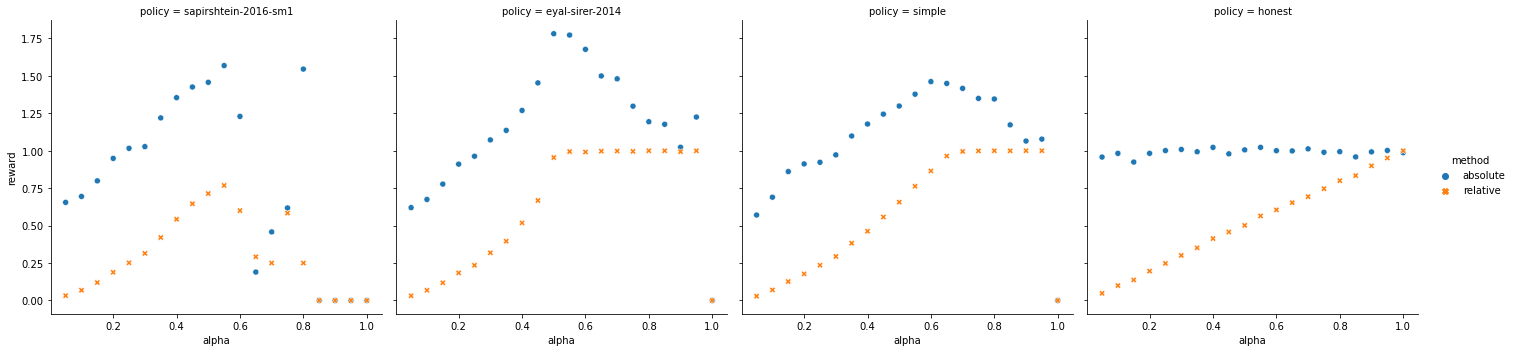

In [4]:
sns.relplot(data=d, x="alpha", y="reward", col="policy", style="method", hue="method")

In the following plot, we translate the 'relative' reward to the normalized scale of the 'absolute' reward method. Observe, that both methods concur.

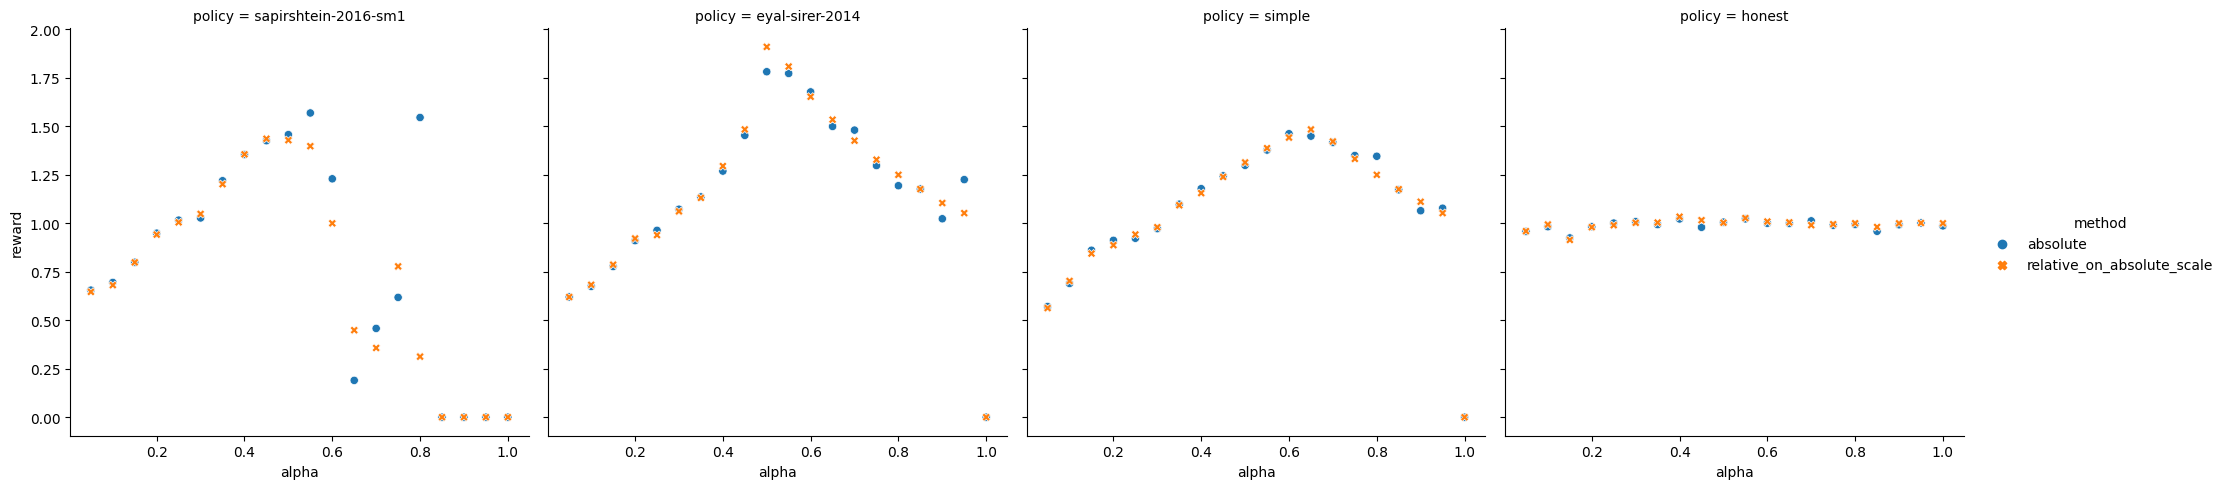

In [5]:
dd = d[d.method == "relative"].copy()
dd.reward = dd.reward / dd.alpha
dd.method = "relative_on_absolute_scale"
dd = pd.concat([d, dd])
sns.relplot(
    data=dd[dd.method != "relative"],
    x="alpha",
    y="reward",
    col="policy",
    hue="method",
    style="method",
)

At last, I subset alpha to .33 - .475 since I have a training run going that covers only this range. The model should learn selfish mining, otherwise it's a bad model. The environment seems to be ok.

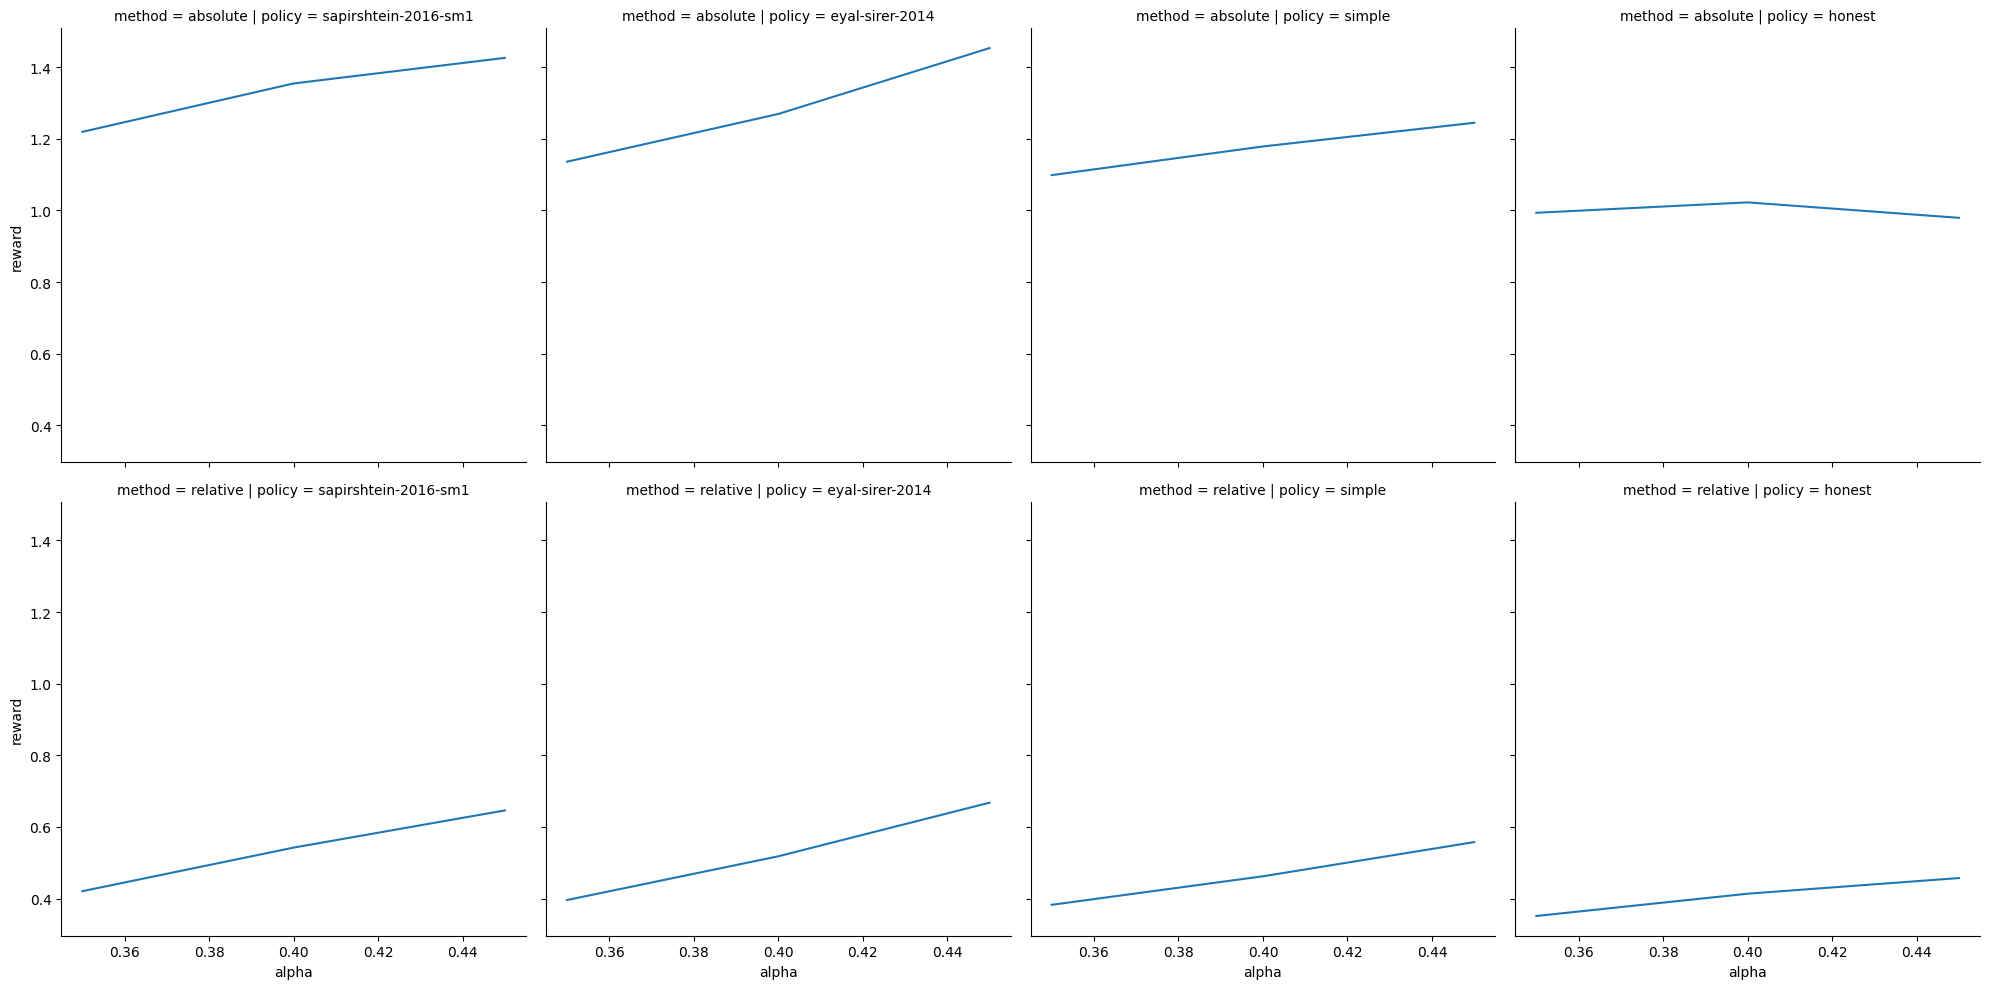

In [6]:
sns.relplot(
    data=d[np.logical_and(d.alpha <= 0.475, d.alpha >= 0.33)],
    kind="line",
    x="alpha",
    y="reward",
    col="policy",
    row="method",
)